# Part 1 : Building the original network model


#### Overview
This Notebook implements the network in [Sustained activity in hierarchical modular neural networks: self-organized criticality and oscillation](https://www.frontiersin.org/articles/10.3389/fncom.2011.00030/full) to the original paper.


### Chapters
Section 1 - 2 builds the network. In section 3, the network code has been extracted out into a class and re-imported. We then test different synaptic strengths to see if we can replicate a graph from the original paper visualizing the parameter space of E/I synaptic strengths.


### 0. Plot configuration


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

%load_ext autoreload
%autoreload 2

plt.style.use(["science"])
plt.rcParams["figure.figsize"] = (8, 8)

### 1. Building the network


In [2]:
import nest
import nest.raster_plot
import pylab

nest.ResetKernel()
n = 4  # number of threads'
dt = 0.1

nest.SetKernelStatus(
    {"local_num_threads": n, "resolution": dt, "overwrite_files": True}
)

nest.SetKernelStatus({"print_time": True})

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: Mar  7 2023 05:58:34

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Apr 03 18:21:25 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


**Model parameters**


In [3]:
N_total = 10_000
N_E = int(N_total * (4 / 5))  # Number of excitatory neurons
N_I = int(N_total * (1 / 5))  # Number of excitatory neurons
N_rec = N_E  # Number of neurons to record

In [4]:
synapse_model = "static_synapse"
neuron_model = "iaf_cond_exp"

neuron_params = {
    "V_m": -60.0,
    "E_L": -60.0,
    "V_th": -50.0,
    "V_reset": -60.0,
    "t_ref": 5.0,
    "E_ex": 0.0,
    "E_in": -80.0,
    "C_m": 100.0,
    "g_L": 10.0,
    # "I_e": 200.0,
    "tau_syn_ex": 5.0,
    "tau_syn_in": 10.0,
}

# Synapse parameters
P_0 = 0.01  # Connection probability
delay = 1.0

J_E = 4.0
J_I = -51.0

# Stimulation
p_rate = 10_000

**Create Neurons**


In [5]:
nodes = nest.Create(neuron_model, N_total, params=neuron_params)
nodes_E = nodes[:N_E]
nodes_I = nodes[N_E:]

nest.SetStatus(nodes, "V_m", -60.0)

**Setting up synapses**


In [6]:
exc_syn_dict = {
    "synapse_model": "static_synapse",
    "weight": J_E,
    "delay": delay,
}
inh_syn_dict = {
    "synapse_model": "static_synapse",
    "weight": J_I,
    "delay": delay,
}

**Connecting the network**


In [7]:
prob_conn_dict = {"rule": "pairwise_bernoulli", "p": P_0}

nest.Connect(
    nodes_E,
    nodes,
    syn_spec=exc_syn_dict,
    conn_spec=prob_conn_dict,
)
nest.Connect(
    nodes_I,
    nodes,
    syn_spec=inh_syn_dict,
    conn_spec=prob_conn_dict,
)

**Add stimualtion and spike detector**


In [8]:
# nest.SetDefaults("spike_recorder", {"to_file": True})
noise = nest.Create("poisson_generator", 1, {"rate": p_rate, "start": 0, "stop": 200})

spikes = nest.Create("spike_recorder", 1, [{"label": "va-py-ex"}])
spikes_E = spikes[:1]

nest.Connect(nodes_E[:N_rec], spikes_E)

In [9]:
nest.Connect(noise, nodes)

## 2. Interact with the network


**Simulate**


In [10]:
simtime = 1000  # ms
# nest.Simulate(simtime)

**Analyze data**


In [11]:
""" rate_iaf = nest.GetStatus(spikes)[0]["n_events"] / ((simtime / 1000.0) * N_rec)
print("Average Rate of recorded electrodes: " + str(rate_iaf) + "Hz")

nest.raster_plot.from_device(spikes_E, hist=True) """

' rate_iaf = nest.GetStatus(spikes)[0]["n_events"] / ((simtime / 1000.0) * N_rec)\nprint("Average Rate of recorded electrodes: " + str(rate_iaf) + "Hz")\n\nnest.raster_plot.from_device(spikes_E, hist=True) '

## 3. Simulate different synaptic strengths


Let's now explore this parameter space of synaptic weights, notice that our parameters are x10 the values on the graph:

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_m/fncom-05-00030-g002.jpg" width="600">

This is done by running a poisson generator for 200ms, then turning it off to see how long the signal survives

**The IS zone**

As the raster plot shows, although the Poisson nose only runs between 0 - 200 ms, the network activity persists until the end of the simulation - 500ms. Indicating that we have found the delicate balance of E / I strength

Starting simulation

Apr 03 18:43:08 NodeManager::prepare_nodes [Info]: 
    Preparing 10002 nodes for simulation.

Apr 03 18:43:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10002
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

[ 100% ] Model time: 1000.0 ms, Real-time factor: 25.5664

Apr 03 18:43:34 SimulationManager::run [Info]: 
    Simulation finished.


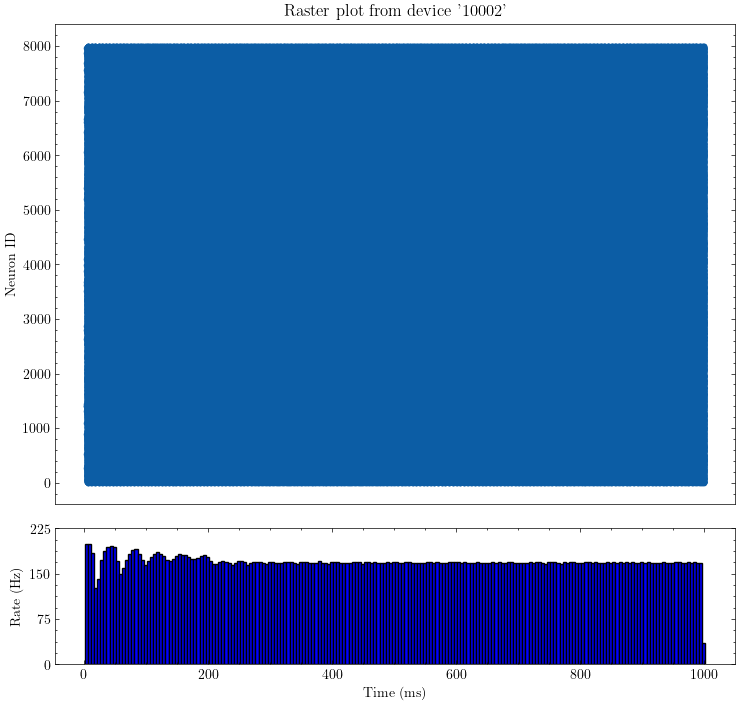

In [20]:
from classes.random_network import RandomNetwork

params_1 = {
    "J_E": 0.5,
    "J_I": -7.0,
    "p_rate": 2_000

}

random_network_1 = RandomNetwork(**params_1)
random_network_1.build()
random_network_1.run(simtime=1000.0)
random_network_1.plot()

**The ET zone**

As the raster plot shows, the network activity dies when the Poisson generator stops.

Starting simulation

Apr 03 18:29:25 NodeManager::prepare_nodes [Info]: 
    Preparing 10002 nodes for simulation.

Apr 03 18:29:25 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10002
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

[ 100% ] Model time: 1000.0 ms, Real-time factor: 20.4636

Apr 03 18:29:46 SimulationManager::run [Info]: 
    Simulation finished.


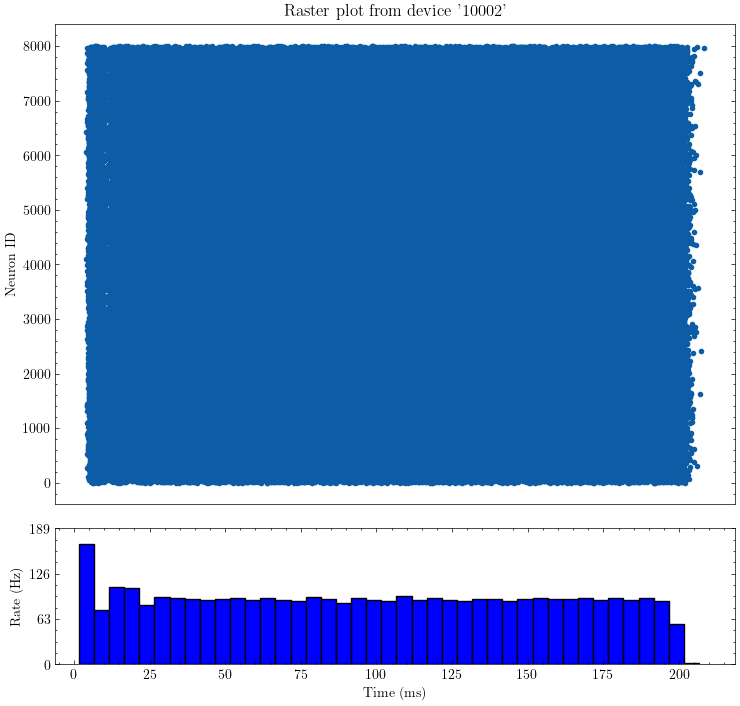

In [19]:
params_2 = {
    "J_E": 0.1,
    "J_I": -0.9,
    "p_rate": 2_000
}

random_network_2 = RandomNetwork(**params_2)
random_network_2.build()
random_network_2.run(simtime=1000.0)
random_network_2.plot()